In [1]:
import networkx as nx
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import random
import numpy as np
import math

In [2]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 100

In [3]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Step 1
## Graph generation, train/test splitting and feature generation

Generate/import graph from avalible `generator` classes

In [4]:
from lib.generators.LFR import LFR
from lib.generators.OLP import OLP


#generator = LFR(n=5000, t1=3, t2=1.1, m=0.1, seed=seed)
generator = OLP(seed=seed)
feature_names = generator.feature_names

Loading file...
File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [5]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [6]:
link_prediction_train['goal'].value_counts()

0    856
1    856
Name: goal, dtype: int64

In [7]:
link_prediction_test['goal'].value_counts()

0    1321
1     177
Name: goal, dtype: int64

In [8]:
classifier_test['goal'].value_counts()

0    1318
1     181
Name: goal, dtype: int64

# Step 2
## Link prediction model

Predict links using one of the avalble link prediction models

In [9]:
from lib.link_prediction_models.RandomForestOnFeatures import RandomForestOnFeatures

model = RandomForestOnFeatures(X_train=link_prediction_train[feature_names], Y_train=link_prediction_train['goal'], random_state=seed)

prob = model.predict_proba(link_prediction_test[feature_names])
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,67,177,0,0.0,0.666667,0.0,0.001055,0.059353,0.0,0.0,0.0,-4.163336e-17,2.433118e-15,-4.430648e-17,0.06
1,1,21,0,0.0,0.666667,0.0,0.000926,0.002252,0.0,0.0,0.0,1.040834e-15,2.525702e-15,-2.072206e-16,0.00
2,43,268,0,0.0,0.666667,0.0,0.000688,0.052759,0.0,0.0,0.0,-6.938894e-18,2.527446e-15,1.502162e-16,0.98
3,13,243,0,0.0,0.333333,0.0,0.001291,0.081229,0.0,0.0,0.0,2.099015e-16,2.377141e-15,-1.879043e-16,0.88
4,214,276,0,0.0,0.333333,0.0,0.000410,0.085572,0.0,0.0,0.0,-1.018283e-15,2.141790e-15,-9.174760e-16,0.00


Feature importance based on mean decrease in impurity

|                      |          0 |
|:---------------------|-----------:|
| com_ne               | 0.0588508  |
| short_path           | 0.00364014 |
| LHN                  | 0.130488   |
| page_rank_pers_edges | 0.0624098  |
| pref_attach          | 0.0566481  |
| jacc_coeff           | 0.151136   |
| adam_adar            | 0.103392   |
| res_alloc_ind        | 0.248272   |
| svd_edges            | 0          |
| svd_edges_dot        | 0.0486683  |
| svd_edges_mean       | 0.136495   | 



Feature importance based on mean accuracy decrease

|                      |           0 |
|:---------------------|------------:|
| com_ne               |  0.0012016  |
| short_path           | -0.00106809 |
| LHN                  | -0.0101469  |
| page_rank_pers_edges |  0.00640854 |
| pref_attach          | -0.00307076 |
| jacc_coeff           | -0.00987984 |
| adam_adar            | -0.0123498  |
| res_alloc_ind        |  0.037984   |
| svd

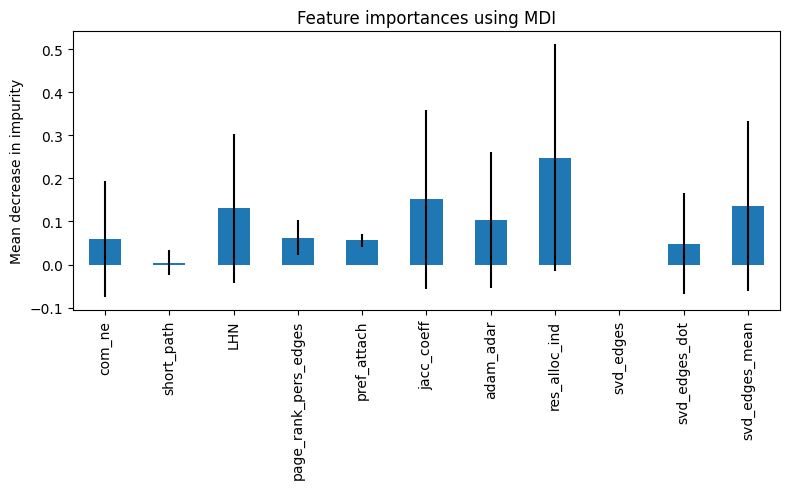

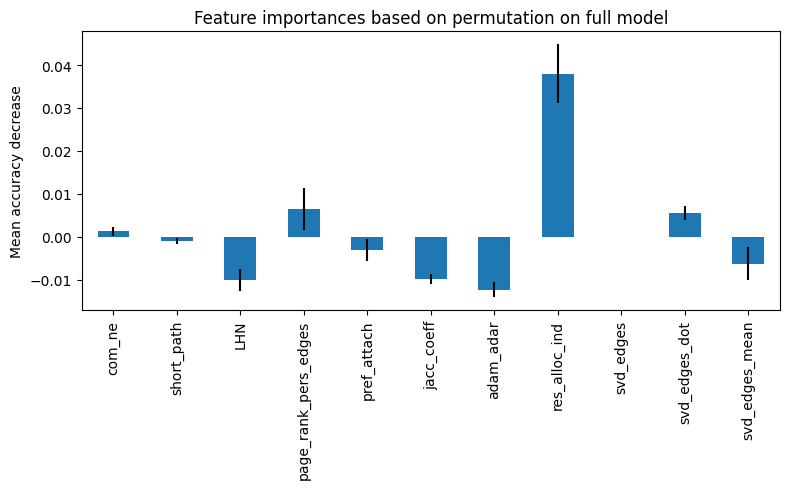

In [10]:
# RANDOM FOREST FEATURE IMPORTANCE

# mean decrease in impurity

importances = model.clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
print('Feature importance based on mean decrease in impurity\n')
print(forest_importances.to_markdown(), '\n\n\n')

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# feature permutation

from sklearn.inspection import permutation_importance

result = permutation_importance(model.clf, link_prediction_test[feature_names],  link_prediction_test['goal'], n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
print('Feature importance based on mean accuracy decrease\n')
print(forest_importances.to_markdown())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances based on permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

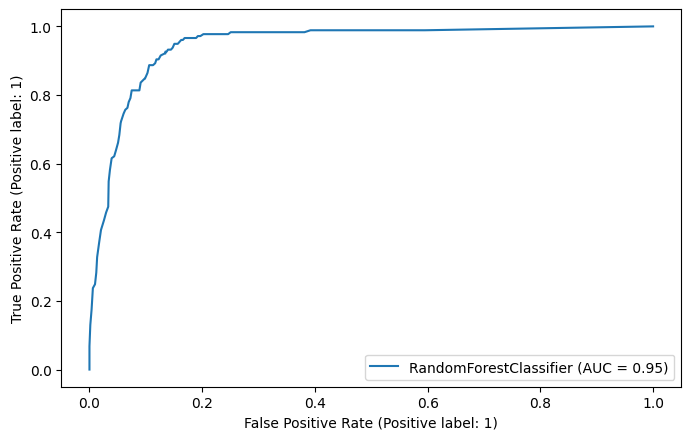

In [11]:
from sklearn import metrics


metrics.plot_roc_curve(model.get_model(), link_prediction_test[feature_names], link_prediction_test['goal'])  

# Step 3
## Quality class analisys

In [12]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,67,177,0,0.0,0.666667,0.0,0.001055,0.059353,0.0,0.0,0.0,-4.163336e-17,2.433118e-15,-4.430648e-17,0.06,0.06
1,1,21,0,0.0,0.666667,0.0,0.000926,0.002252,0.0,0.0,0.0,1.040834e-15,2.525702e-15,-2.072206e-16,0.00,0.00
2,43,268,0,0.0,0.666667,0.0,0.000688,0.052759,0.0,0.0,0.0,-6.938894e-18,2.527446e-15,1.502162e-16,0.98,0.98
3,13,243,0,0.0,0.333333,0.0,0.001291,0.081229,0.0,0.0,0.0,2.099015e-16,2.377141e-15,-1.879043e-16,0.88,0.88
4,214,276,0,0.0,0.333333,0.0,0.000410,0.085572,0.0,0.0,0.0,-1.018283e-15,2.141790e-15,-9.174760e-16,0.00,0.00


In [13]:
# statistics on error
link_proba['abs_error'].describe()

count    1498.000000
mean        0.461175
std         0.415424
min         0.000000
25%         0.020000
50%         0.370000
75%         0.940000
max         1.000000
Name: abs_error, dtype: float64

In [14]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.37

In [15]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,67,177,0,0.0,0.666667,0.0,0.001055,0.059353,0.0,0.0,0.0,-4.163336e-17,2.433118e-15,-4.430648e-17,0.06,0.06,1
1,1,21,0,0.0,0.666667,0.0,0.000926,0.002252,0.0,0.0,0.0,1.040834e-15,2.525702e-15,-2.072206e-16,0.00,0.00,1
2,43,268,0,0.0,0.666667,0.0,0.000688,0.052759,0.0,0.0,0.0,-6.938894e-18,2.527446e-15,1.502162e-16,0.98,0.98,0
3,13,243,0,0.0,0.333333,0.0,0.001291,0.081229,0.0,0.0,0.0,2.099015e-16,2.377141e-15,-1.879043e-16,0.88,0.88,0
4,214,276,0,0.0,0.333333,0.0,0.000410,0.085572,0.0,0.0,0.0,-1.018283e-15,2.141790e-15,-9.174760e-16,0.00,0.00,1


In [16]:
link_proba['quality_label'].value_counts()

0    962
1    750
Name: quality_label, dtype: int64

# Step 4
## Quality class prediction

In [17]:
# train for quality class prediction
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

clf = LogisticRegression(random_state=seed)  #clf = LogisticRegression(random_state=seed, class_weight='balanced')
#clf = DecisionTreeClassifier(random_state=seed)
#clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=seed)

clf.fit(link_proba[feature_names], link_proba['quality_label'])

LogisticRegression(random_state=616)

In [18]:
# testing the classifier

pred = clf.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [19]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.030000000000000027

In [20]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,54,191,0,0.000000,0.333333,0.000000,0.001898,0.095223,0.000000,0.000000,0.000000,-8.604228e-16,2.515718e-15,2.708337e-17,0.00,1,0.00,1
1,223,241,0,0.042553,0.000000,0.002151,0.001863,0.148303,0.033898,0.474007,0.029418,8.326673e-17,4.255319e-02,6.451613e-02,0.10,1,0.10,0
2,75,86,0,0.191489,0.000000,0.004155,0.004392,0.347113,0.104651,2.340016,0.200146,-2.498002e-16,1.914894e-01,1.578947e-01,0.37,0,0.37,0
3,164,245,0,0.021277,0.000000,0.011765,0.005532,0.012385,0.047619,0.434294,0.100000,-8.604228e-16,2.127660e-02,5.882353e-02,0.40,1,0.40,0
4,31,191,0,0.000000,0.333333,0.000000,0.002148,0.120959,0.000000,0.000000,0.000000,4.718448e-16,2.377037e-15,-5.578762e-17,0.00,1,0.00,1


In [21]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     750
0                     749
dtype: int64

In [22]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1133
0                           366
dtype: int64

In [23]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    clf.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1499.000000
1,Accuracy,0.691127
2,Precision,0.758683
3,Recall,0.691127
4,F1 score,0.669491


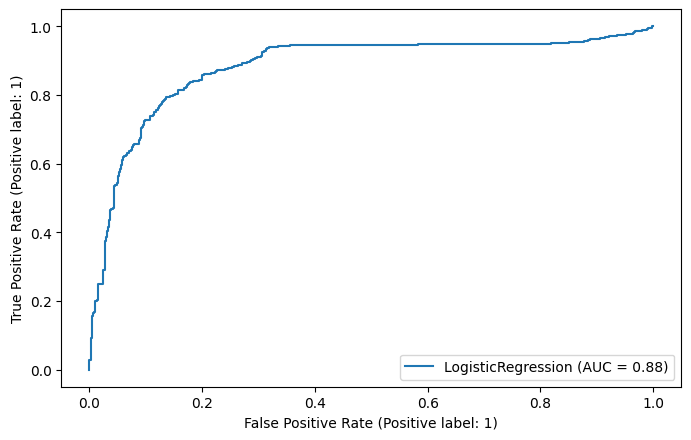

In [24]:
metrics.plot_roc_curve(clf, classifier_test[feature_names], classifier_test['true_quality_label'])  

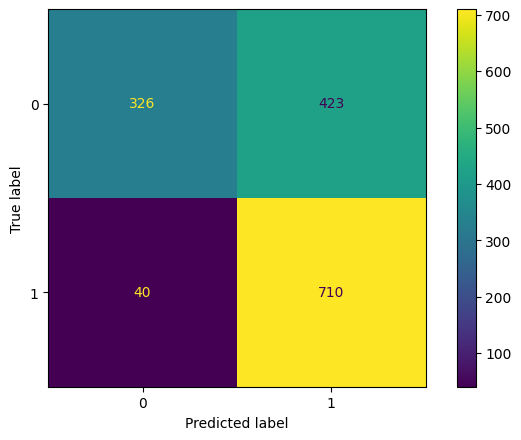

In [25]:
metrics.plot_confusion_matrix(clf, classifier_test[feature_names], classifier_test['true_quality_label'])

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

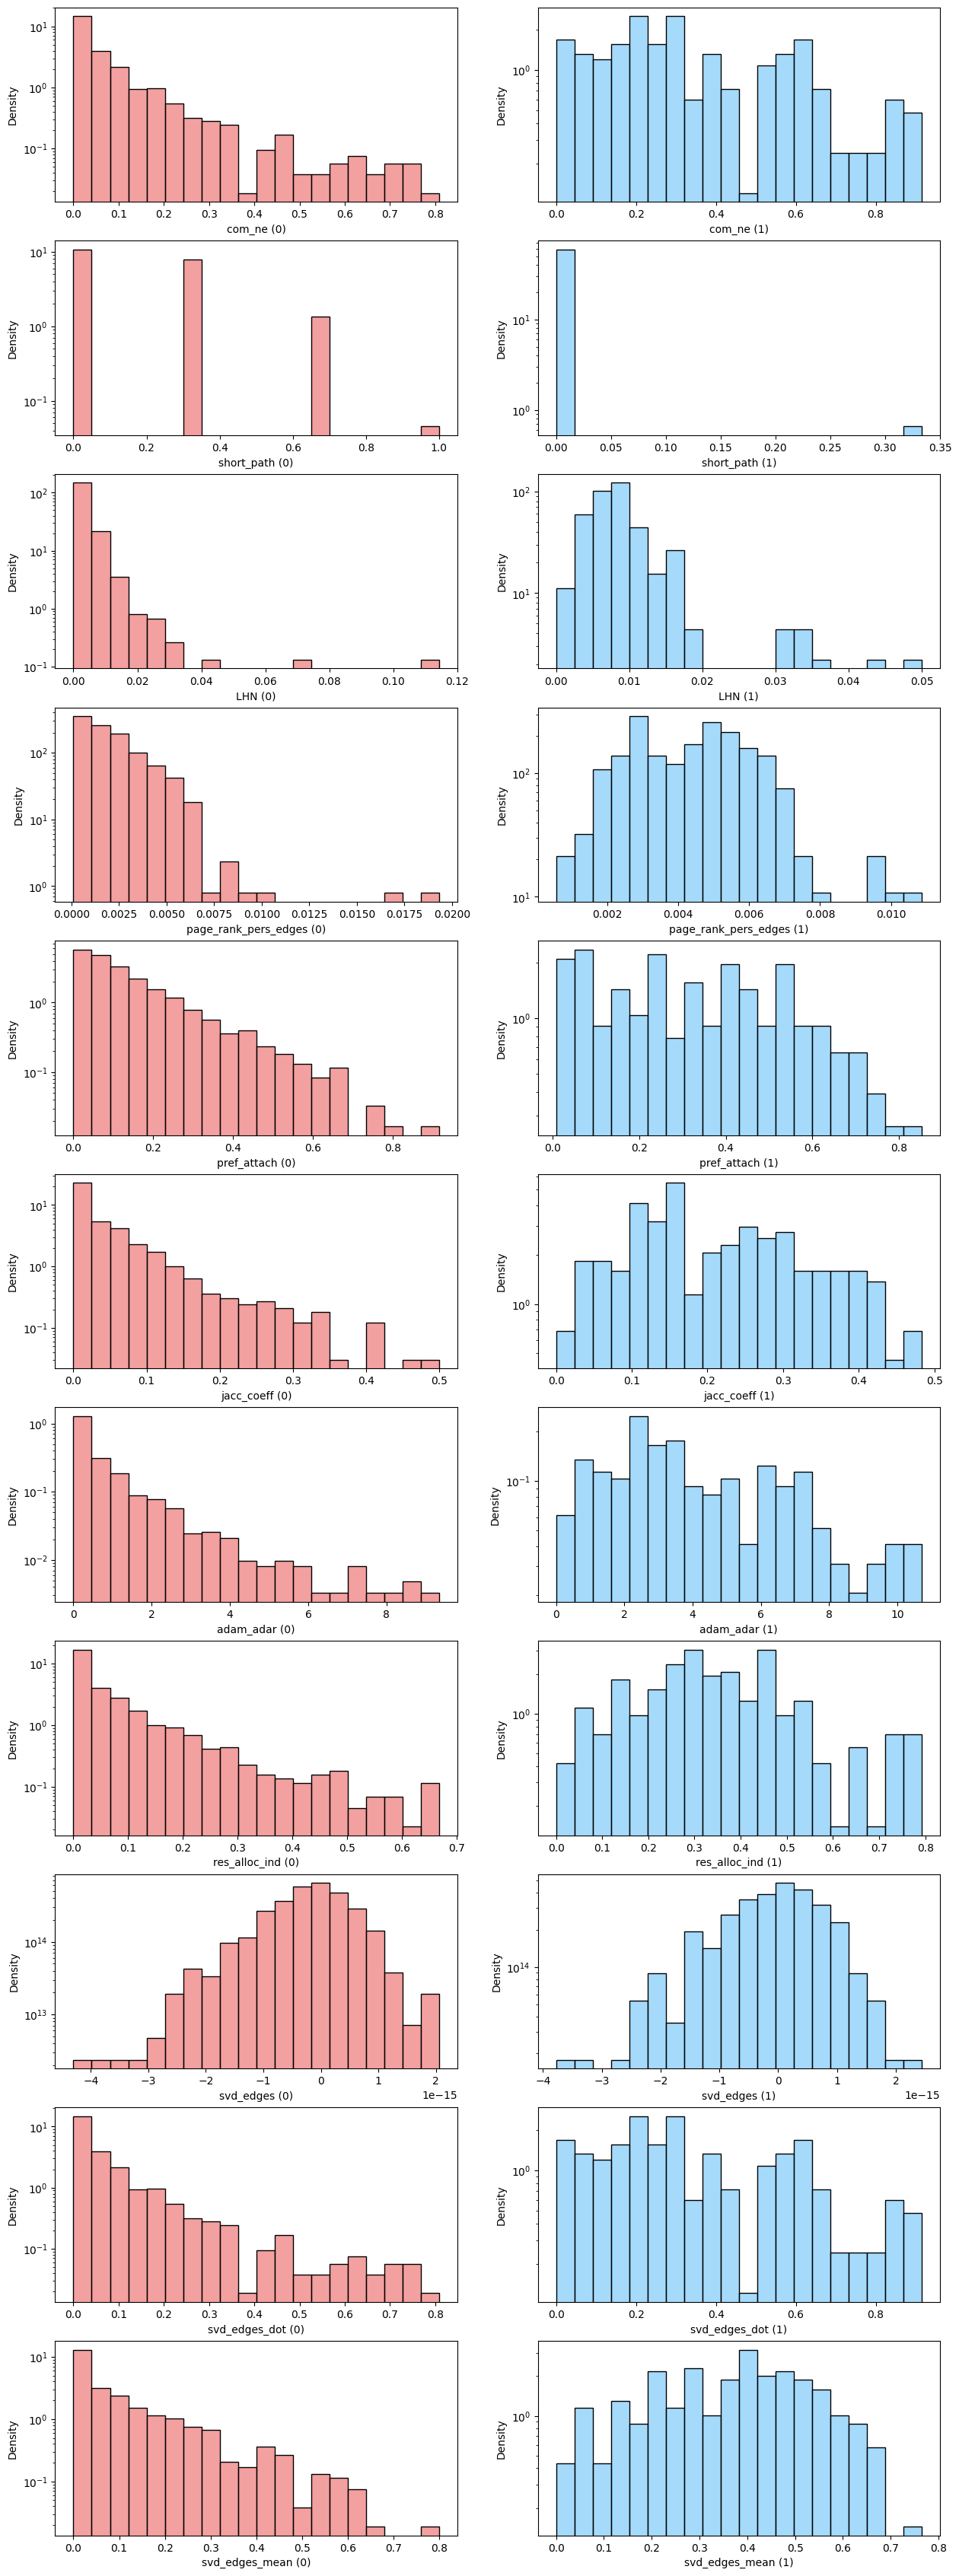

In [27]:
mpl.rcParams['figure.figsize'] = [15, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=2, nrows=len(feature_names))

colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    for j in [0, 1]:
        data = classifier_test[classifier_test['goal'] == j]
        sns.histplot(data, x=feature, ax=axs[i][j], bins=20, color=colors[j], stat='density')
        axs[i][j].set(xlabel=f'{feature} ({j})', ylabel='Density')
        axs[i][j].set_yscale("log")


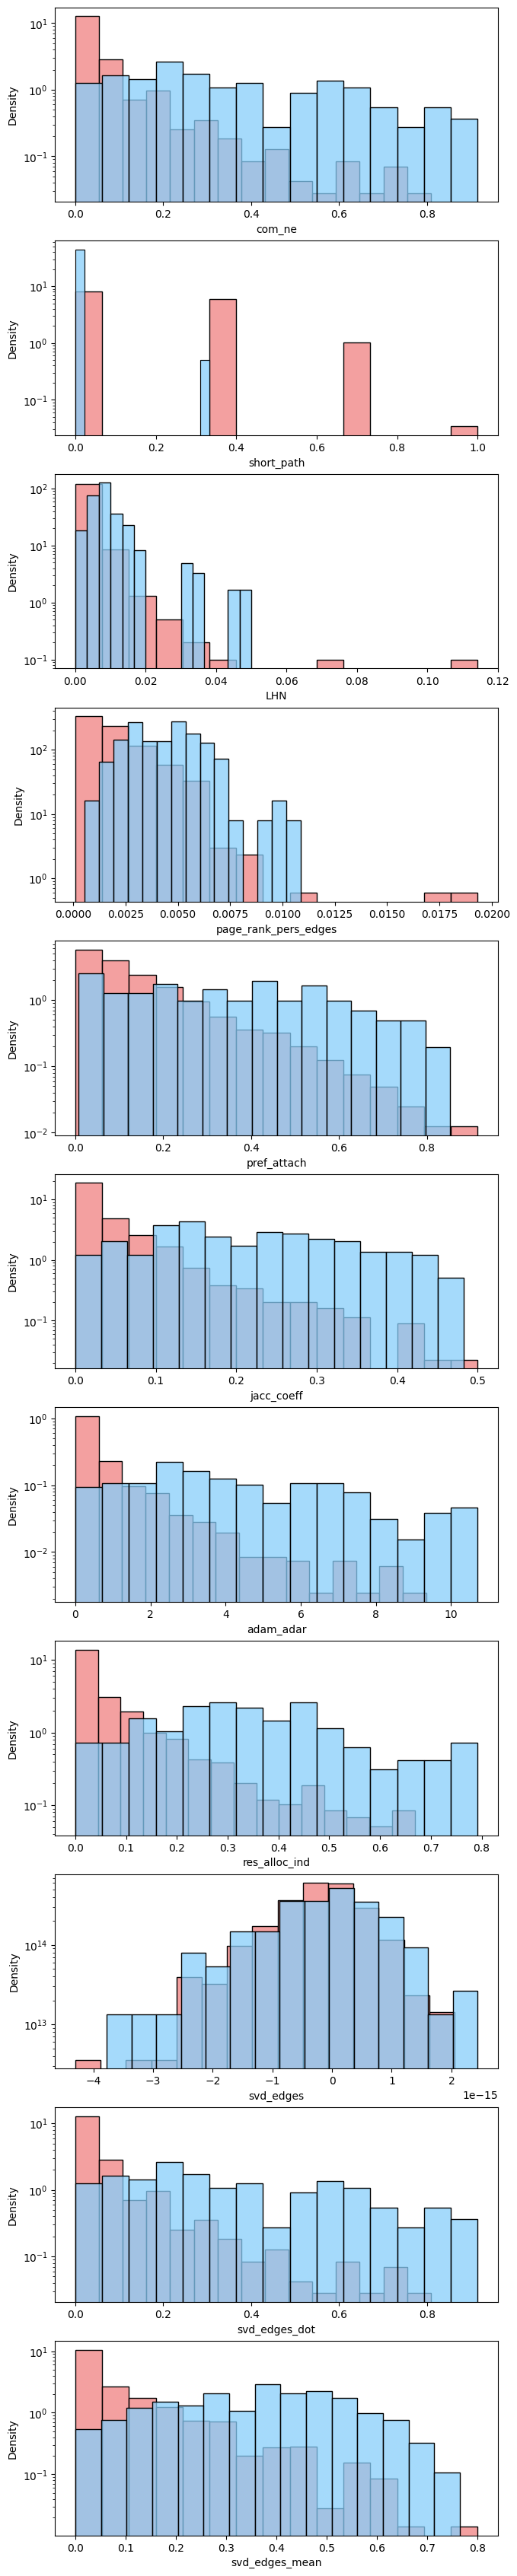

In [29]:
mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))

colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    for j in [0, 1]:
        data = classifier_test[classifier_test['goal'] == j]
        sns.histplot(data, x=feature, ax=axs[i], bins=15, color=colors[j], stat='density')
        axs[i].set(xlabel=feature, ylabel='Density')
        axs[i].set_yscale("log")
